In [8]:
import numpy as np
import pandas as pd
import pyro.distributions as dist
from scipy import stats
import torch
import seaborn as sns

import matplotlib.pyplot as plt
from sklearn.metrics import normalized_mutual_info_score
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns

import copy
import json

import argparse

import sys
import os
from utils_functions import *

# Set the parent directory
parent_dir = "../../"
sys.path.insert(0, parent_dir)
import new_model as mobster_mv
from utils.BoundedPareto import BoundedPareto
from utils.create_beta_pareto_dataset import *

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
num_iter = 2000
num_dataset = 15

N = 500  # number of mutations
K = 3  # number of clusters
D = 2  # number of samples
purity = 1.0
coverage = 100

create_folder(N,K,D,purity,coverage)

here0
here0
tensor([0.2485, 0.1833, 0.5683])
tensor([124.2333,  91.6404, 284.1263])
np.sum(pi) 500
here01
here1
No GPU available.
RUN WITH K = 3 AND SEED = 40
Minimum detected VAF: tensor(0.0510)
Iteration 0: Loss = 1969218.0238198994
Iteration 100: Loss = 1829911.445042296
Iteration 200: Loss = 1809377.1364999672
Iteration 300: Loss = 1803928.6480031782
Iteration 400: Loss = 1801981.1506437487
Inference lk:  -3601.928444186586
Final lk (integr):  tensor(-3632.5830, grad_fn=<SumBackward0>)
n_params:  45
n:  tensor(500)
lk:  tensor(-3632.5830, grad_fn=<SumBackward0>)
bic: 7544.8232421875 

Time taken for K = 3 and seed = 40: 2.308 seconds
RUN WITH K = 3 AND SEED = 41
Minimum detected VAF: tensor(0.0510)
Iteration 0: Loss = 1970256.5512950607
Iteration 100: Loss = 1830075.2640981532
Iteration 200: Loss = 1810066.2760597912
Iteration 300: Loss = 1803916.7082142788
Iteration 400: Loss = 1801978.133855818
Inference lk:  -3601.8135390164425
Final lk (integr):  tensor(-3632.5039, grad_fn=<Sum

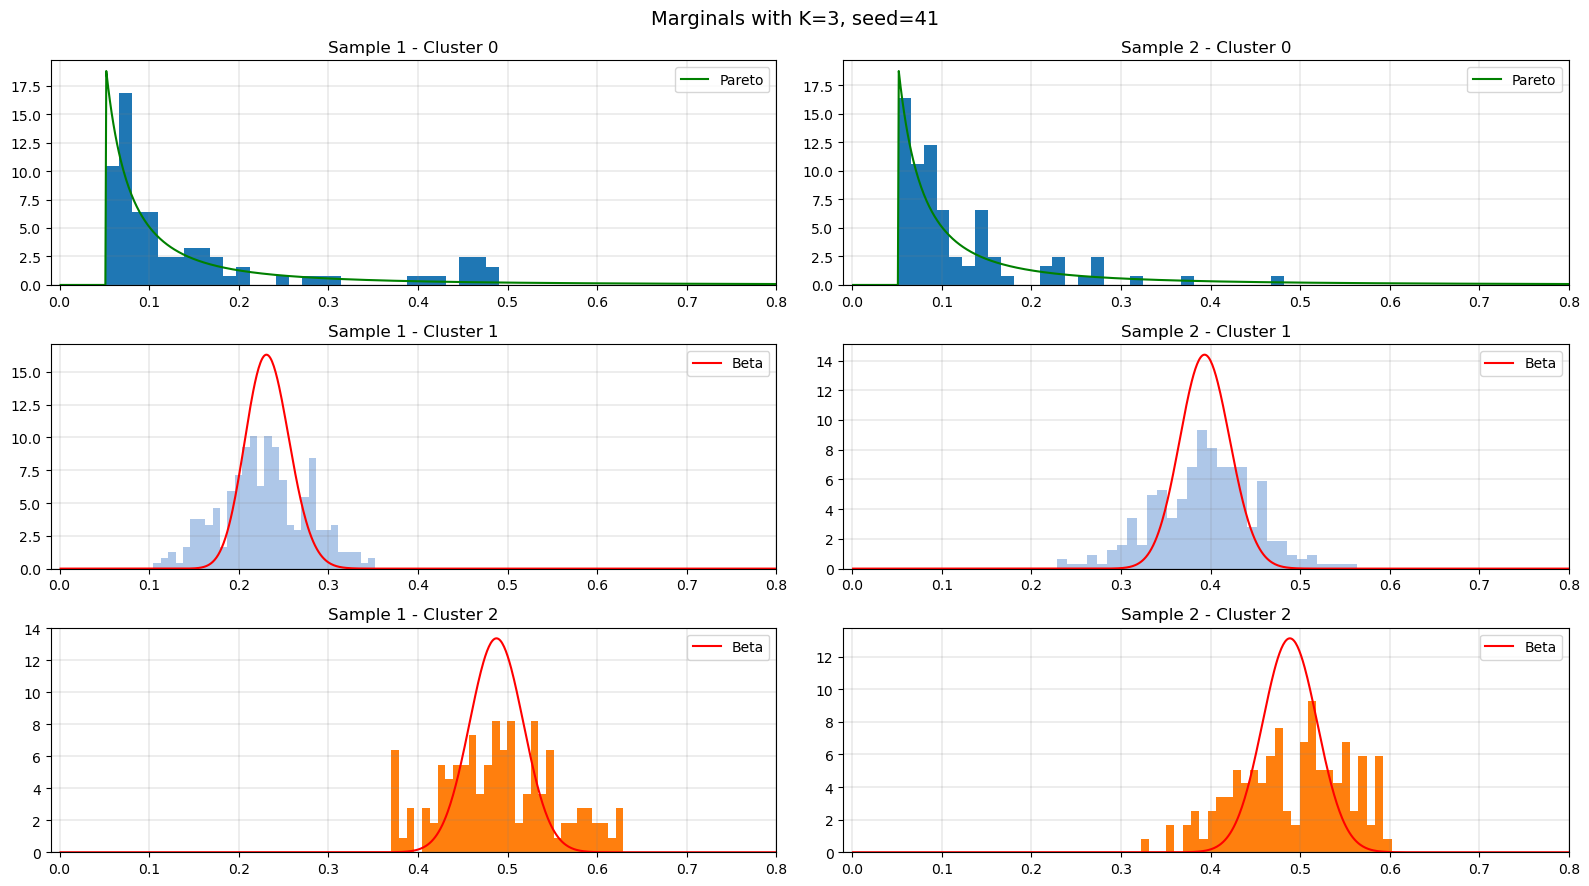

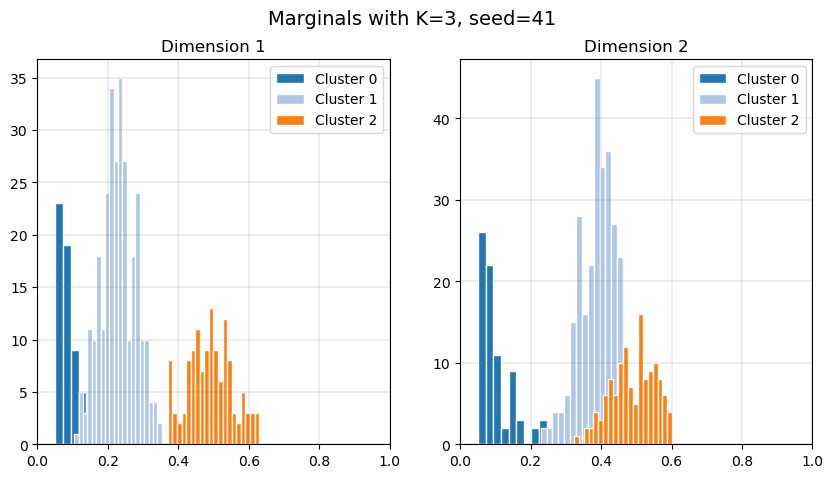

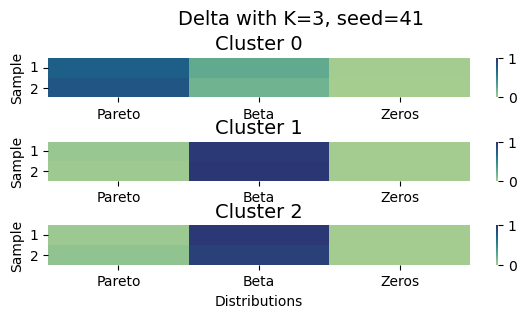

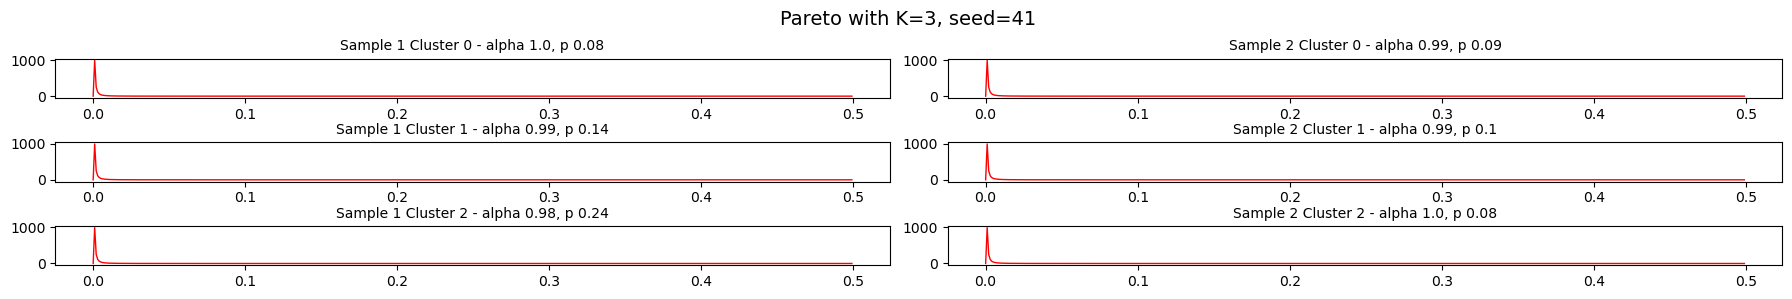

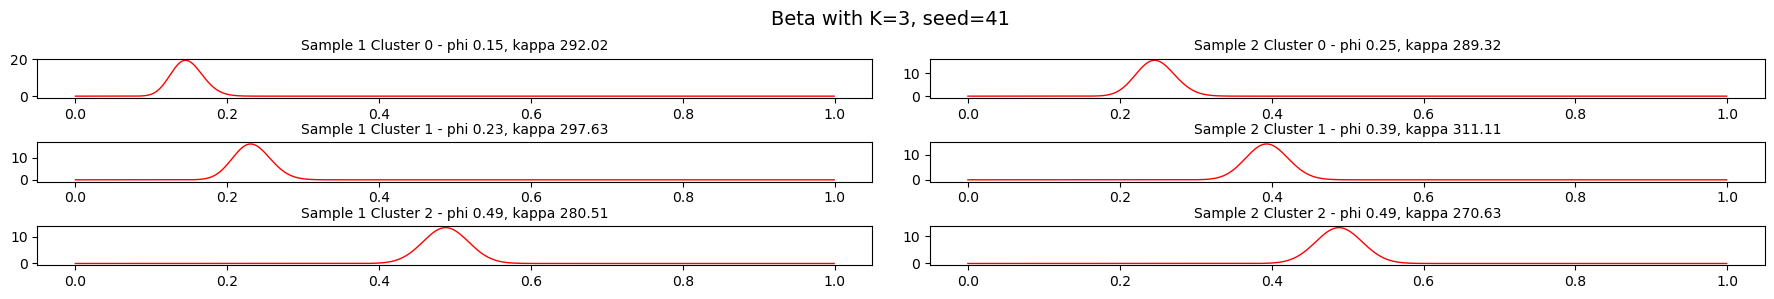

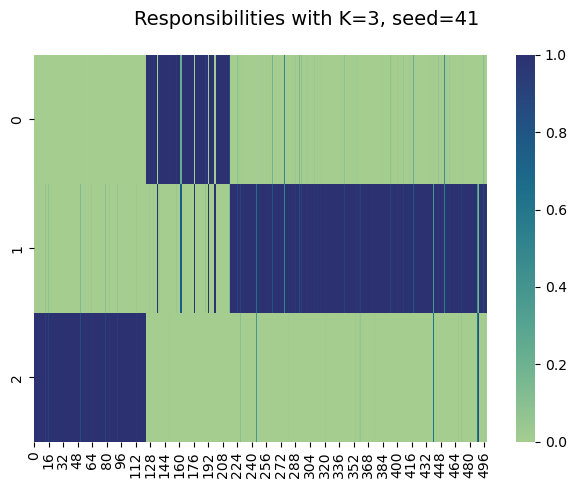

tensor([ 85, 288, 127])


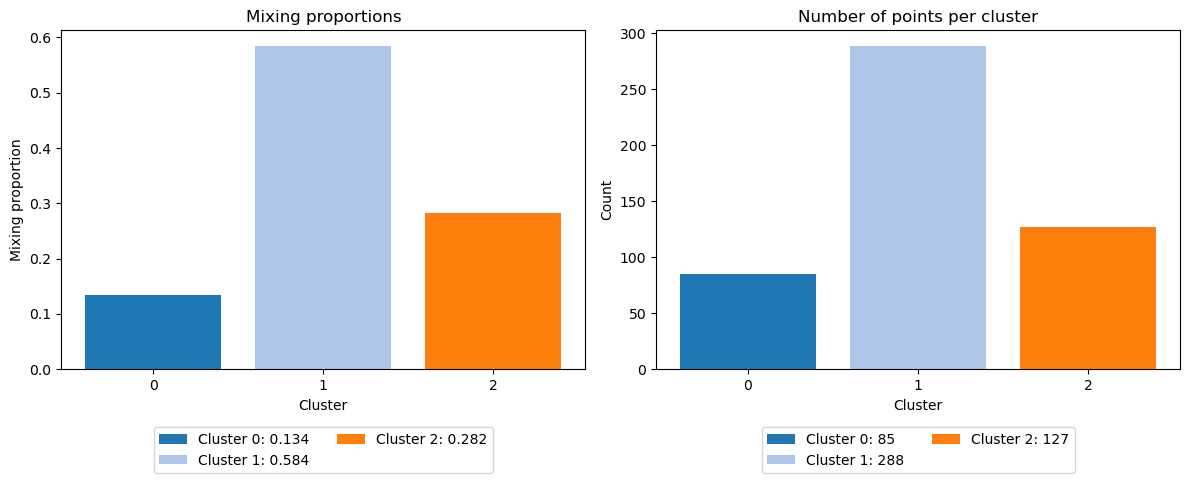

Selected number of clusters is 3 with seed 41
here2
here3
here4
here5
here0
here0
tensor([0.2929, 0.6011, 0.1060])
tensor([146.4573, 300.5672,  52.9755])
np.sum(pi) 500
here01
here1
No GPU available.
RUN WITH K = 3 AND SEED = 40
Minimum detected VAF: tensor(0.0500)
Iteration 0: Loss = 1837160.6615800061
Iteration 100: Loss = 1733878.6597762716
Iteration 200: Loss = 1703714.7906540623
Iteration 300: Loss = 1695351.1989923944
Iteration 400: Loss = 1694077.0305845458
Inference lk:  -3386.3077231405814
Final lk (integr):  tensor(-3503.5557, grad_fn=<SumBackward0>)
n_params:  45
n:  tensor(500)
lk:  tensor(-3503.5557, grad_fn=<SumBackward0>)
bic: 7286.7685546875 

Time taken for K = 3 and seed = 40: 2.307 seconds
RUN WITH K = 3 AND SEED = 41
Minimum detected VAF: tensor(0.0500)
Iteration 0: Loss = 1837088.1902889614
Iteration 100: Loss = 1736220.028204001
Iteration 200: Loss = 1705092.924344427
Iteration 300: Loss = 1695105.4900009916
Iteration 400: Loss = 1693827.2144221335
Iteration 500: 

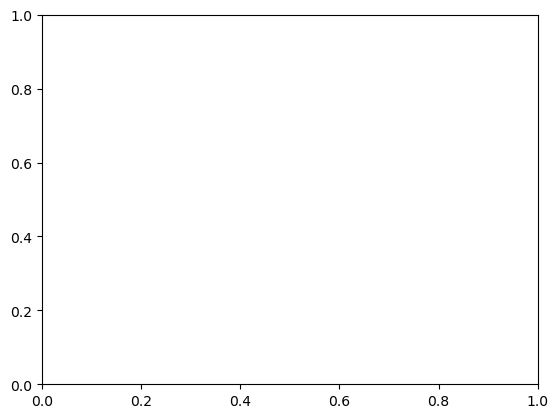

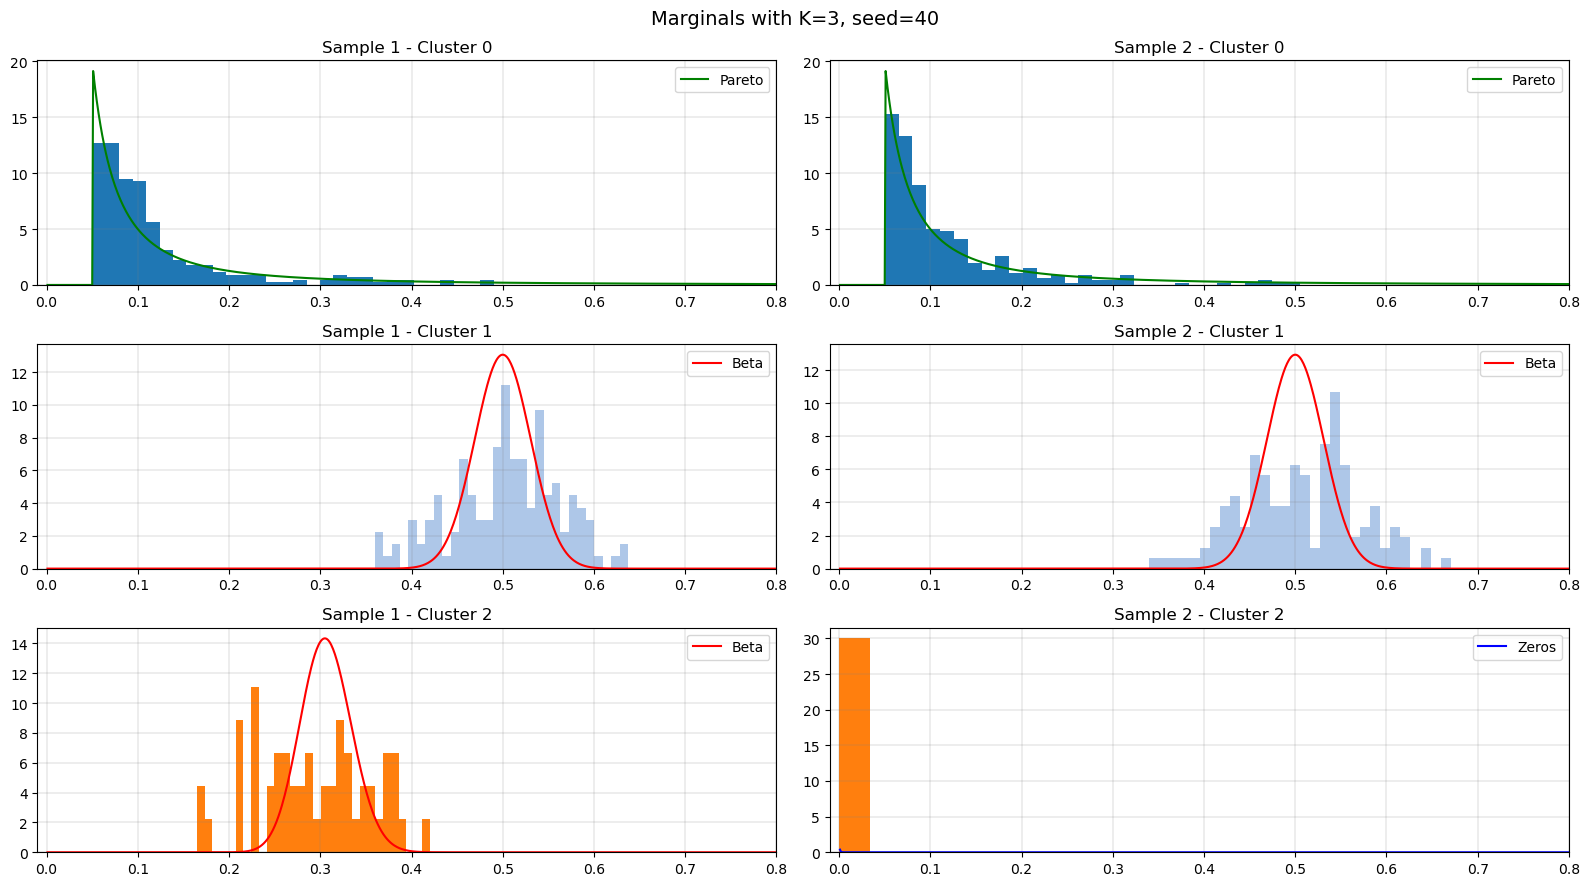

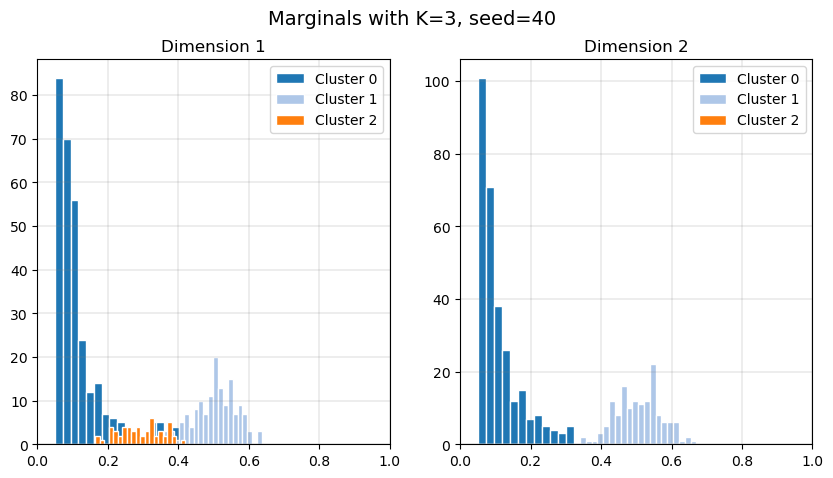

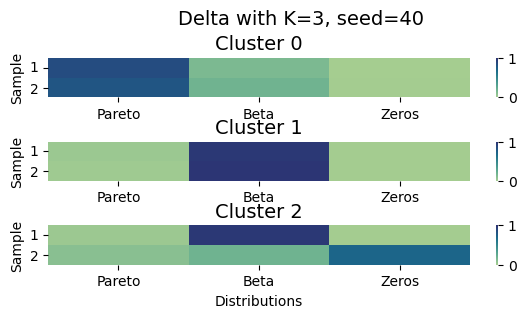

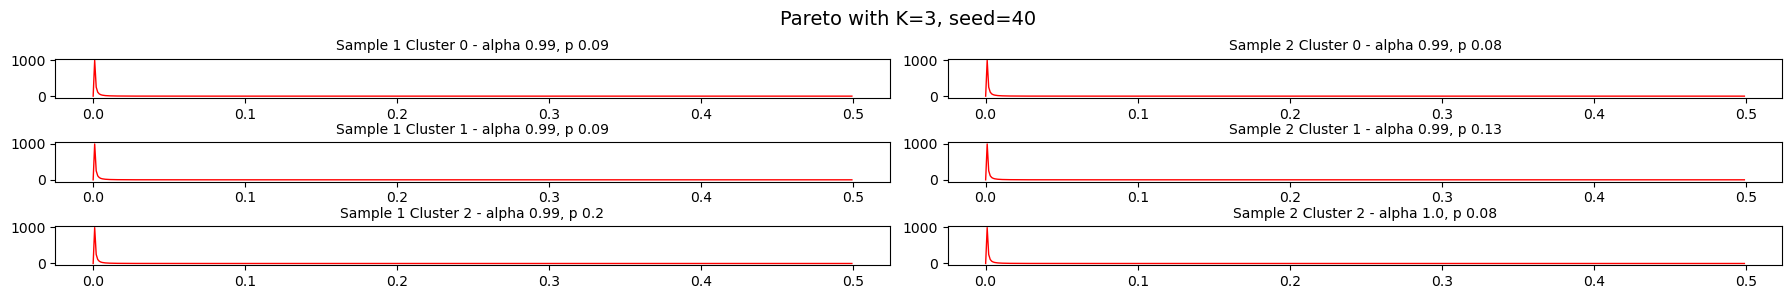

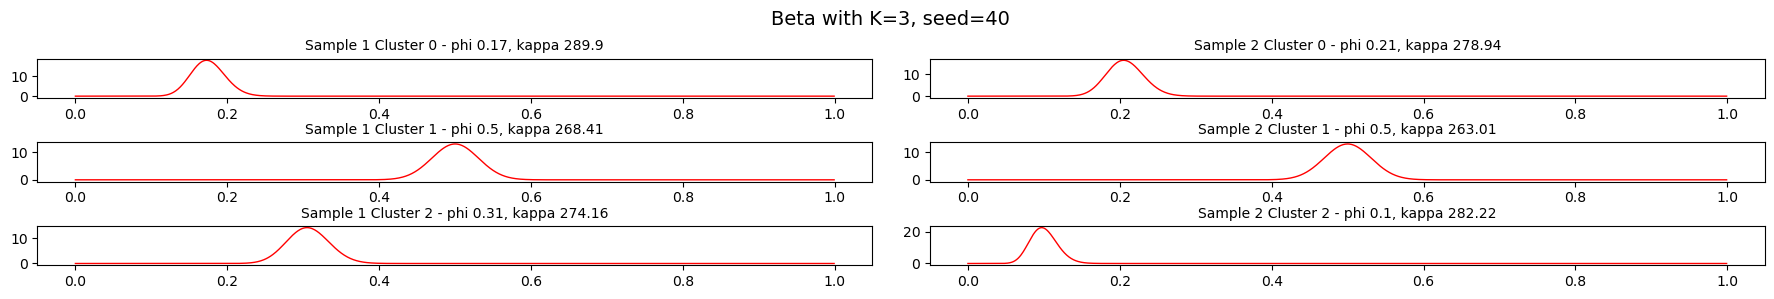

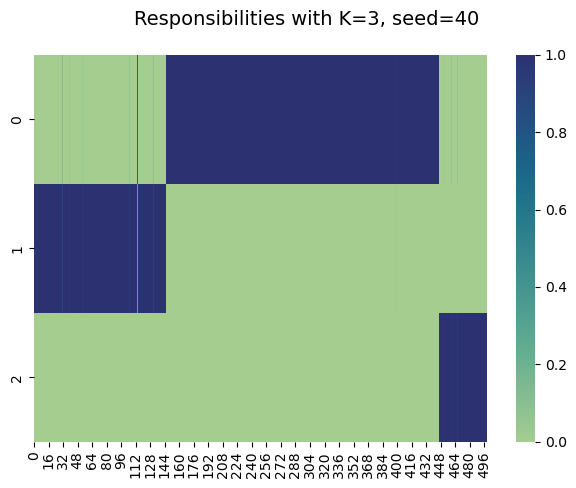

tensor([302, 145,  53])


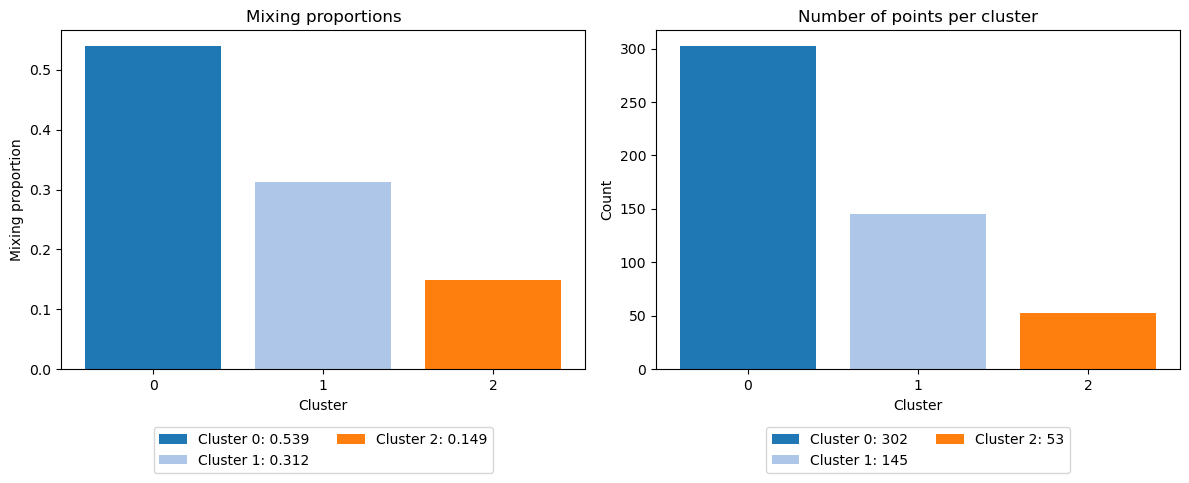

Selected number of clusters is 3 with seed 40
here2
here3


KeyboardInterrupt: 

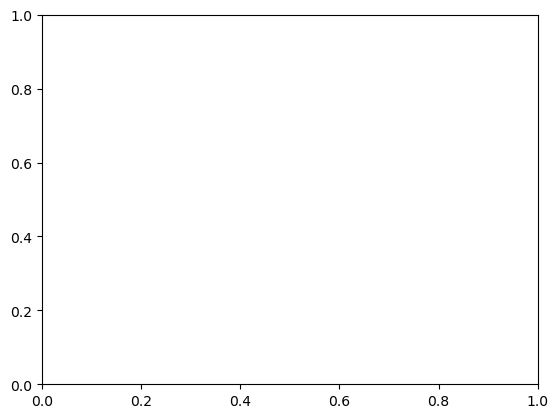

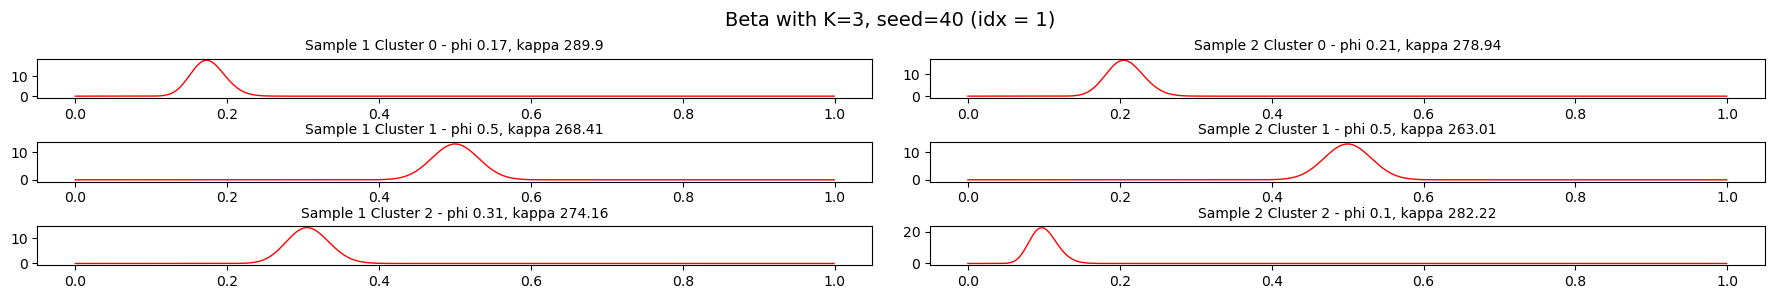

In [7]:
nmi_list = []
ari_list = []
acc_list = []
conf_matrix_list = []
seed = 0
for idx in range(num_dataset):
    seed1 = seed+idx+K+N
    pyro.set_rng_seed(seed1)
    torch.manual_seed(seed1)
    np.random.seed(seed1)

    # Sample mixing proportions for clusters and multiply by N to obtain the number of data in each cluster
    pi = sample_mixing_prop(K, min_value=0.05) * N
    print(pi/N)
    print(pi)
    # pi = dist.Dirichlet(torch.ones(K)).sample() * N  # Number of data in each cluster
    pi = np.round(pi.numpy()).astype('int')

    # Adjust proportions to ensure they sum to N
    print("np.sum(pi)", np.sum(pi))
    if np.sum(pi) < N:
        diff = N - np.sum(pi)
        pi[-1] += diff
    elif np.sum(pi) > N:
        diff = np.sum(pi) - N
        pi[-1] -= diff
    NV, DP, cluster_labels, type_labels_data, type_labels_cluster, phi_param_data, kappa_param_data, alpha_param_data, phi_param_cluster, kappa_param_cluster, alpha_param_cluster  = generate_data_new_model(N, K, pi, D, purity, coverage)

    plot_scatter_real(NV, DP, N, K, D, type_labels_cluster, cluster_labels, idx, purity, coverage)  
    plot_marginals_real(NV, DP, N, K, D, type_labels_cluster, cluster_labels, phi_param_cluster, kappa_param_cluster, alpha_param_cluster, idx, purity, coverage)

    # Run the model
    if K != 3:
        K_list = [K - 2, K - 1, K, K + 1, K + 2, K + 3]
    else:
        K_list = [K]
    
    seed_list = [40,41]
    mb_list, best_K, best_seed = mobster_mv.fit(NV, DP, num_iter = num_iter, K = K_list, seed = seed_list, lr = 0.01, purity = purity)
    mb = mb_list[K_list.index(best_K)]
    
    pred_cluster_labels, pred_type_labels_data, pred_phi_param_data, pred_kappa_param_data, pred_alpha_param_data = retrieve_info(mb, N, D)

    plot_final(mb, N, K, idx, purity, coverage)
    plot_final_marginals(mb, N, K, D, idx, purity, coverage)
    # plt.savefig(f"plots/p_{str(purity).replace('.', '')}_cov_{coverage}/D_{D}/real_marginals/N_{N}_K_{K}_D_{D}_real_{idx}.png")
    general_folder = f"plots/p_{str(purity).replace('.', '')}_cov_{coverage}/D_{D}/"
    # for m in range(len(mb_list)):
    data_folder = general_folder + "responsib_deltas/"
    plot_deltas_gen(mb, N, K, D, idx, savefig = True, data_folder = data_folder)
    plot_responsib_gen(mb, N, K, D, idx, savefig = True, data_folder = data_folder)
    
    data_folder = general_folder + "betas_paretos/"
    plot_paretos_gen(mb, N, K, D, idx, savefig = True, data_folder = data_folder)
    plot_betas_gen(mb, N, K, D, idx, savefig = True, data_folder = data_folder)

    data_folder = general_folder + "model_selection/"
    plot_model_selection_gen(mb_list, N, K_list, K, seed_list, D, idx, savefig = True, data_folder = data_folder)

    data_folder = general_folder + "loss_lks/"
    plot_loss_lks_gen(mb, N, K, D, idx, savefig = True, data_folder = data_folder)

    
    column_names = ['NV', 'DP', 'True_cluster', 'Pred_cluster', 
        'True_distribution', 'Pred_distribution', 'True_phi', 'Pred_phi', 
        'True_kappa', 'Pred_kappa', 'True_alpha', 'Pred_alpha']
    df = pd.DataFrame(columns=column_names)

    df['NV'] = [[round(val, 3) for val in row.tolist()] for row in NV]
    df['DP'] = [[round(val, 3) for val in row.tolist()] for row in DP]
    df['True_cluster'] = cluster_labels.tolist()  # No rounding needed, they are integer labels
    df['Pred_cluster'] = pred_cluster_labels.tolist()
    df['True_distribution'] = [[round(val, 3) for val in row.tolist()] for row in type_labels_data]
    df['Pred_distribution'] = [[round(val, 3) for val in row.tolist()] for row in pred_type_labels_data]
    df['True_phi'] = [[round(val, 3) for val in row.tolist()] for row in phi_param_data]
    df['Pred_phi'] = [[round(val, 3) for val in row.tolist()] for row in pred_phi_param_data]
    df['True_kappa'] = [[round(val, 3) for val in row.tolist()] for row in kappa_param_data]
    df['Pred_kappa'] = [[round(val, 3) for val in row.tolist()] for row in pred_kappa_param_data]
    df['True_alpha'] = [[round(val, 3) for val in row.tolist()] for row in alpha_param_data]
    df['Pred_alpha'] = [[round(val, 3) for val in row.tolist()] for row in pred_alpha_param_data]

    csv_filename = f"./results/p_{str(purity).replace('.', '')}_cov_{coverage}/D_{D}/csv/N_{N}_K_{K}_D_{D}_df_{idx}.csv"
    df.to_csv(csv_filename, index=False)

    dict_copy = copy.copy(mb.__dict__)
    dict_copy = convert_to_list(dict_copy)
    
    # filename = f'saved_objects/p_{str(purity).replace('.', '')}_cov_{coverage}/D_{D}/N_{N}_K_{K}_D_{D}_pred_{idx}.txt'
    filename = f'saved_objects/p_{str(purity).replace(".", "")}_cov_{coverage}/D_{D}/N_{N}_K_{K}_D_{D}_pred_{idx}.txt'
    with open(filename, 'w') as f:
        f.write(json.dumps(dict_copy) + '\n')
    print('here4')
    # Measure NMI
    true_labels = cluster_labels
    predicted_labels = pred_cluster_labels

    nmi = normalized_mutual_info_score(true_labels, predicted_labels)
    nmi_list.append(nmi)

    ari = adjusted_rand_score(true_labels, predicted_labels)
    ari_list.append(ari)

filename = f"results/p_{str(purity).replace('.', '')}_cov_{coverage}/D_{D}/nmi/nmi_N_{N}_K_{K}_D_{D}.txt"
with open(filename, "w") as file:
    for item in nmi_list:
        file.write(f"{item}\n")  # Writing each item on a new line

filename = f"results/p_{str(purity).replace('.', '')}_cov_{coverage}/D_{D}/ari/ari_N_{N}_K_{K}_D_{D}.txt"
with open(filename, "w") as file:
    for item in ari_list:
        file.write(f"{item}\n")  # Writing each item on a new line

    """
    # Compute accuracy on predicted distributions (Pareto or Beta)
    true_distributions = np.array([[0. if elem == 'P' else 1. for elem in sublist] for sublist in unique_types])
    delta = mb.params["delta_param"]
    pred_distribtions = np.zeros((mb.K, mb.NV.shape[1]))
    for k in range(mb.K):
        for d in range(mb.NV.shape[1]):
            delta_kd = delta[k, d]
            maxx = torch.argmax(delta_kd)
            if maxx == 0: # Pareto
                pred_distribtions[k,d] = 0
            else:
                pred_distribtions[k,d] = 1
    accuracy = accuracy_score(true_labels, predicted_labels)
    acc_list.append(accuracy)
    
    filename = f"results/acc/ari_N_{N}_sub_{K1}"
    with open(filename, "w") as file:
        for item in acc_list:
            file.write(f"{item}\n")  # Writing each item on a new line

    # Confusion matrix
    conf_matrix = confusion_matrix(true_distributions.flatten(), pred_distribtions.flatten(), labels=[0, 1])
    conf_matrix_list.append(conf_matrix)
    filename = f"results/conf_matrix/ari_N_{N}_sub_{K1}"
    with open(filename, "w") as file:
        for item in conf_matrix_list:
            file.write(f"{item}\n")  # Writing each item on a new line
    """